## Time Series Forecasting 5

### Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import mplfinance as mpf
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf # Connects Plotly to Pandas
# Makes Plotly work in your Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import requests # Get URL data
from bs4 import BeautifulSoup # Manipulate URL data
import json
from pandas import DataFrame as df

### Making Predictions with ARIMA

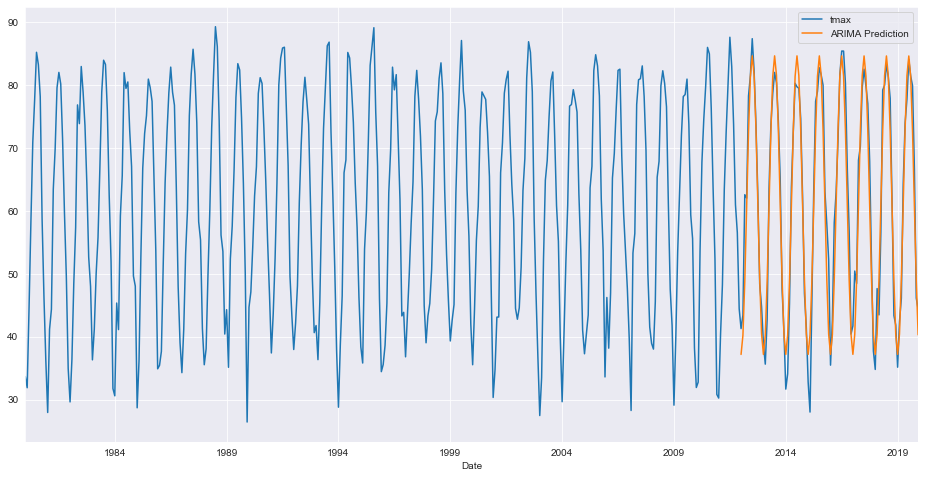

In [695]:
# Write dataframe to csv
# pitt_df.to_csv('Pitt-M-Temp-80-pres.csv')

p_df = pd.read_csv('Pitt-M-Temp-80-pres.csv', index_col='Date', parse_dates=True)

from statsmodels.tsa.arima_model import ARIMA, ARMA, ARIMAResults, ARMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# pip install pmdarima
from pmdarima import auto_arima

# Seasonal Data
# p_df.plot()

# Tells us what model to use
# ARIMA(2,0,2)(0,0,0)
# auto_arima(p_df, seasonal=True, trace=True).summary() 
# Split the data into a training and testing set
p_df.size # 480
train_df = p_df.iloc[:384] # 80%
test_df = p_df.iloc[384:] # 20%

# Create the model
mod = ARIMA(train_df, order=(2,0,2))
# Fit the model to get the results
res = mod.fit()
# Get the summarized forcast which is the same as auto_arima
res.summary()

# Get predicted values
start = len(train_df)
end = len(train_df) + len(test_df) - 1
prediction = res.predict(start, end).rename('ARIMA Prediction')

# Plot Prediction
p_df.plot(figsize=(16,8), legend=True)
prediction.plot(legend=True)

### Stationarity

**Definition**
A stationary data set does not change the way it changes over time. Basically it has a constant slope or rate of change. 

**Why Use Them**
They are easy to analyze and they are required often during time series analysis. 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
appl_df = pd.read_csv('appl2.csv', index_col='Date', parse_dates=True)

appl_df = appl_df.asfreq('d') # Change frequency to day
appl_df = appl_df.fillna(method='ffill')
appl_df.index # Check frequency

In [ ]:
# Used to measure whether our data is stationary
from statsmodels.tsa.stattools import adfuller
# The Augmented Dickey-Fuller Test tells us whether our results
# are stationary. If the P-Value is very small that means
# there is a very low probability that our reults are random
def adf_test(timeseries):
    print ('Dickey-Fuller Test')
    # AIC aims to minimize corresponding information
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print (dfoutput)

In [5]:
flight_df = sns.load_dataset('flights')
flight_df['day'] = '01'
flight_df['month'] = pd.to_datetime(flight_df.month, format='%B').dt.month
flight_df['date'] = pd.to_datetime(flight_df[['year', 'month', 'day']])
flight_df.drop('year', axis=1, inplace=True)
flight_df.drop('month', axis=1, inplace=True)
flight_df.drop('day', axis=1, inplace=True)
flight_df.set_index('date', inplace=True)
flight_df.index.freq = 'MS'

### Checking Mean, Variance and Dickey Fuller

Mean 1 : tmax    60.862379
dtype: float64
Mean 2 : tmax    61.27377
dtype: float64
Variance 1 : tmax    291.969897
dtype: float64
Variance 2 : tmax    294.172683
dtype: float64
Dickey-Fuller Test
Test Statistic                -6.013137e+00
p-value                        1.556204e-07
#Lags Used                     1.800000e+01
Number of Observations Used    4.610000e+02
dtype: float64
Dickey-Fuller Test
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
dtype: float64


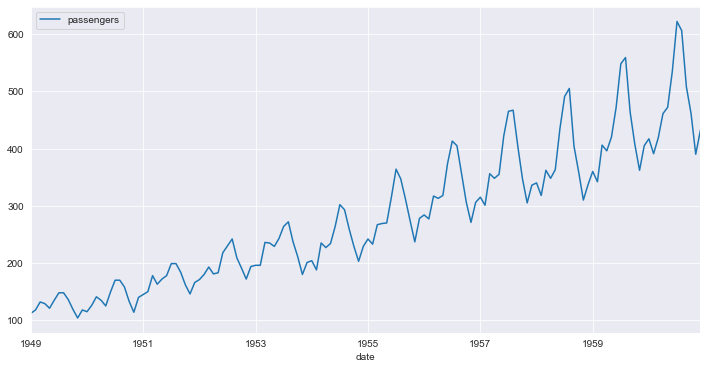

In [703]:
# For a dataset to be stationary the data must have a constant
# mean and variance. We can test this by spliting the data
# and testing mean and variance.
d_set = p_df
# Get midpoint
split = round(len(d_set) / 2)
# Split into 2 datasets at midpoint
d_set1 = d_set[:split]
d_set2 = d_set[split:]
print("Mean 1 :", d_set1.mean())
print("Mean 2 :", d_set2.mean())
print("Variance 1 :", d_set1.var())
print("Variance 2 :", d_set2.var())

# This Dickey Fuller test from before shows I have a Test
# Statistic of -6. The more negative this value is the more
# likely the data is stationary. 
adf_test(p_df)
# Our sample size is 480. A Dickey-Fuller look-up table 
# at sample size 500 says that we can be certain 95% that 
# our data is stationary if the test statistic is less
# than -3.98 in all situations. 
p_df.size

# Our flight data in comparison has a high test statistic and
# a P-Value over 0.05 which shows it isn't stationary
flight_df.plot()
adf_test(flight_df)

### Making Data Stationary

Dickey-Fuller Test
Test Statistic                -1.036431e+01
p-value                        2.352014e-18
#Lags Used                     1.300000e+01
Number of Observations Used    4.650000e+02
dtype: float64
Dickey-Fuller Test
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
dtype: float64


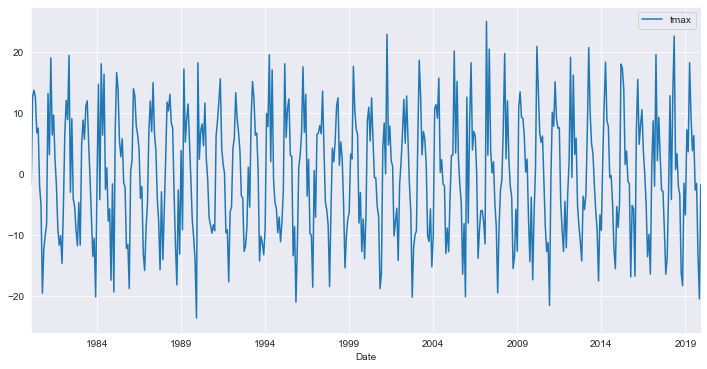

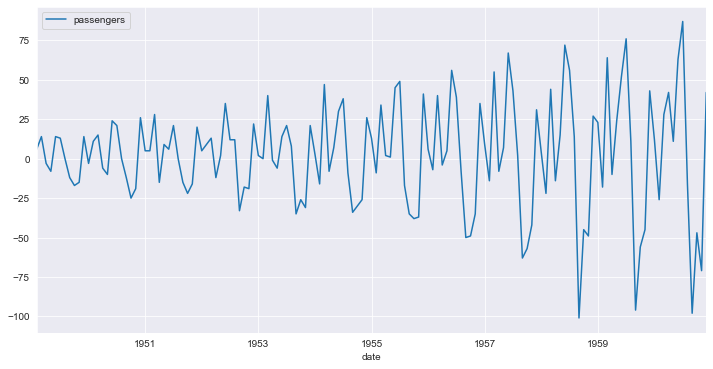

In [730]:
# Use Pandas to difference the dataframe and make the data 
# stationary
diff_df = p_df.diff().dropna()
diff_df.plot()
adf_test(diff_df)

# If we do the same with our flight data we get a stationary
# mean, but not a stationary variance
diff2_df = flight_df.diff().dropna()
diff2_df.plot()
adf_test(diff2_df)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3374.468, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5347.862, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3581.108, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4761.543, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3407.714, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3423.529, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3357.634, Time=0.18 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=3377.559, Time=0.13 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=2851.025, Time=0.36 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, Time=0.63 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=2825.150, Time=0.48 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(4,0,4)(0,0,0)[0]             : AIC=inf, Time=0.66 sec
 ARIMA(3,0,5)(0,0,0)[0]             : AIC=inf, Time=0

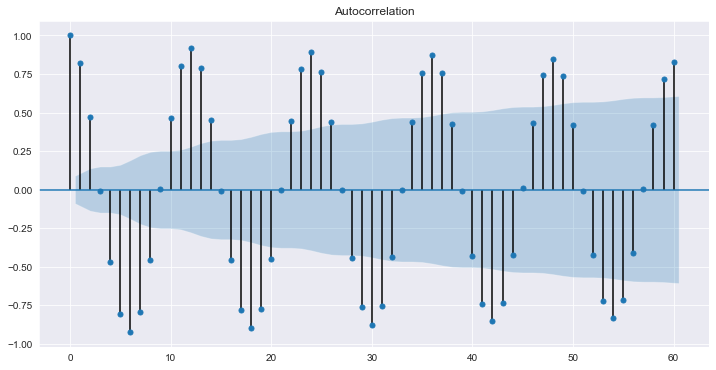

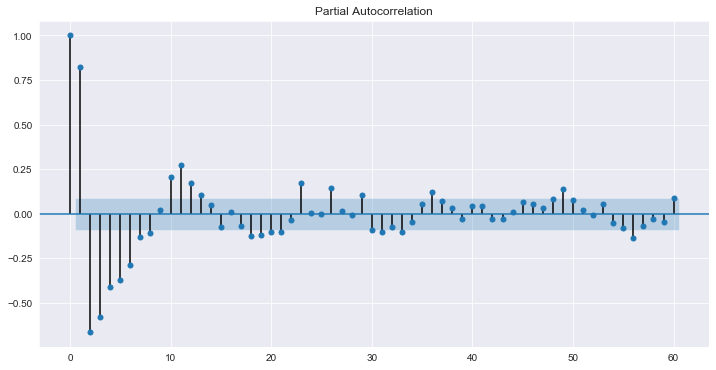

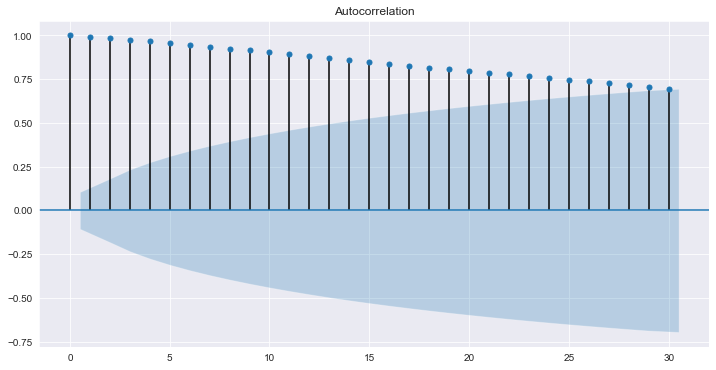

In [771]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Check to see seasonal component
res = seasonal_decompose(p_df, model='add')
# res.plot();

# Even though I tell it it isn't seasonal it overrides me
# If I don't use trace. Otherwise ARIMA(4,0,5)
auto_arima(p_df, seasonal=False, trace=True).summary()

# How is Integration determined? If we run Dickey Fuller on
# the undifferenced data we see that the P-Value is under 
# 0.05 so there is no reason to difference it
adf_test(p_df)

# How do we determine which is more significant AR or MA?
# If PACF has a sharp cutoff then add AR to the model. There
# are between 2 to 5 cutoffs so you should test for the values
# of AR for 2 and 5 which is what auto_arima does.
 
plot_acf(p_df, lags=60);
plot_pacf(p_df, lags=60);

# How do we find the MA value? If there was a slow decline like we
# see with this Apple price data it is suggested that we us AR
# over MA, but that isn't true with our temperature data. That
# implies that we need to test for MA values greater than AR.
# There is a lot of guessing here which is why we use auto_arima
plot_acf(appl_df, lags=30);